In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [1]:
from datasets import load_dataset

dataset_name = "dim/nfs_pix2pix_1920_1080_v5"
# dataset_name = "dim/nfs_pix2pix_1920_1080_v5_upscale_2x_raw"
# dataset_name = "dim/nfs_pix2pix_1920_1080_v6"
dataset = load_dataset(dataset_name, num_proc=4)
dataset = dataset["train"]

import os


# os.chdir("/code/img2img_turbo/src")
import argparse


import numpy as np


from PIL import Image
import torch


from torchvision import transforms


import torchvision.transforms.functional as F


from img2img_turbo.src.pix2pix_turbo import Pix2PixLight


from img2img_turbo.src.image_prep import canny_from_pil


from img2img_turbo.src.benchmark import merge_loras

model_name = ""


# model_path = "/code/img2img_turbo/models/model_20001.pkl"


model_path = "img2img_turbo/output/pix2pix_turbo/nfs_pix2pix_1736652315/checkpoints/model_7201.pkl"


use_fp16 = not False


# initialize the model


model = Pix2PixLight(dtype=torch.float16)


model.set_eval()


# if use_fp16:


# model.to(torch.bfloat16)


# model.unet.to(torch.bfloat16)


# model.vae.to(torch.bfloat16)


T = transforms.Compose(
    [
        transforms.Resize(512, interpolation=transforms.InterpolationMode.NEAREST),
        transforms.CenterCrop(512),
    ]
)

In [2]:
len(dataset)

852

In [2]:
model.unet = model.unet.from_pretrained(
    "img2img_turbo/output/pix2pix_light/nfs_pix2pix_1740323104/checkpoints/model_15001/unet"
    # "img2img_turbo/output/pix2pix_light/nfs_pix2pix_1739912522/checkpoints/model_15001/unet"
)
model.vae = model.vae.from_pretrained(
    "img2img_turbo/output/pix2pix_light/nfs_pix2pix_1740323104/checkpoints/model_15001/vae"
    # "img2img_turbo/output/pix2pix_light/nfs_pix2pix_1739912522/checkpoints/model_15001/vae"
)
model.unet = model.unet.to(model.sched.betas.dtype).cuda()
model.vae = model.vae.to(model.sched.betas.dtype).cuda()
model.unet.requires_grad_(False)
model.vae.requires_grad_(False)
""

The config attributes {'block_out_channels': [64, 64, 64, 64]} were passed to AutoencoderTiny, but are not expected and will be ignored. Please verify your config.json configuration file.


''

In [ ]:
def Fourier_filter(x, threshold, scale):
    # FFT
    x_freq = fft.fftn(x, dim=(-2, -1))
    x_freq = fft.fftshift(x_freq, dim=(-2, -1))
    
    B, C, H, W = x_freq.shape
    mask = torch.ones((B, C, H, W)).cuda() 

    crow, ccol = H // 2, W //2
    mask[..., crow - threshold:crow + threshold, ccol - threshold:ccol + threshold] = scale
    x_freq = x_freq * mask

    # IFFT
    x_freq = fft.ifftshift(x_freq, dim=(-2, -1))
    x_filtered = fft.ifftn(x_freq, dim=(-2, -1)).real
    
    return x_filtered

class Free_UNetModel(UNetModel):
    """
    :param b1: backbone factor of the first stage block of decoder.
    :param b2: backbone factor of the second stage block of decoder.
    :param s1: skip factor of the first stage block of decoder.
    :param s2: skip factor of the second stage block of decoder.
    """

    def __init__(
        self,
        b1,
        b2,
        s1,
        s2,
        *args,
        **kwargs
    ):
        super().__init__(*args, **kwargs)
        self.b1 = b1 
        self.b2 = b2
        self.s1 = s1
        self.s2 = s2

    def forward(self, x, timesteps=None, context=None, y=None, **kwargs):
        """
        Apply the model to an input batch.
        :param x: an [N x C x ...] Tensor of inputs.
        :param timesteps: a 1-D batch of timesteps.
        :param context: conditioning plugged in via crossattn
        :param y: an [N] Tensor of labels, if class-conditional.
        :return: an [N x C x ...] Tensor of outputs.
        """
        assert (y is not None) == (
            self.num_classes is not None
        ), "must specify y if and only if the model is class-conditional"
        hs = []
        t_emb = timestep_embedding(timesteps, self.model_channels, repeat_only=False)
        emb = self.time_embed(t_emb)

        if self.num_classes is not None:
            assert y.shape[0] == x.shape[0]
            emb = emb + self.label_emb(y)

        h = x.type(self.dtype)
        for module in self.input_blocks:
            h = module(h, emb, context)
            hs.append(h)
        h = self.middle_block(h, emb, context)
        for module in self.output_blocks:
            hs_ = hs.pop()

            # --------------- FreeU code -----------------------
            # Only operate on the first two stages
            if h.shape[1] == 1280:
                hidden_mean = h.mean(1).unsqueeze(1)
                B = hidden_mean.shape[0]
                hidden_max, _ = torch.max(hidden_mean.view(B, -1), dim=-1, keepdim=True) 
                hidden_min, _ = torch.min(hidden_mean.view(B, -1), dim=-1, keepdim=True)
                hidden_mean = (hidden_mean - hidden_min.unsqueeze(2).unsqueeze(3)) / (hidden_max - hidden_min).unsqueeze(2).unsqueeze(3)

                h[:,:640] = h[:,:640] * ((self.b1 - 1 ) * hidden_mean + 1)
                hs_ = Fourier_filter(hs_, threshold=1, scale=self.s1)
            if h.shape[1] == 640:
                hidden_mean = h.mean(1).unsqueeze(1)
                B = hidden_mean.shape[0]
                hidden_max, _ = torch.max(hidden_mean.view(B, -1), dim=-1, keepdim=True) 
                hidden_min, _ = torch.min(hidden_mean.view(B, -1), dim=-1, keepdim=True)
                hidden_mean = (hidden_mean - hidden_min.unsqueeze(2).unsqueeze(3)) / (hidden_max - hidden_min).unsqueeze(2).unsqueeze(3)

                h[:,:320] = h[:,:320] * ((self.b2 - 1 ) * hidden_mean + 1)
                hs_ = Fourier_filter(hs_, threshold=1, scale=self.s2)
            # ---------------------------------------------------------

            h = th.cat([h, hs_], dim=1)
            h = module(h, emb, context)
        h = h.type(x.dtype)
        if self.predict_codebook_ids:
            return self.id_predictor(h)
        else:
            return self.out(h)

In [11]:
# не работает для sd turbo
# from safetensors.torch import load_file
# from diffusers.loaders.lora_conversion_utils import (
#     _convert_non_diffusers_lora_to_diffusers,
# )


# state_dict = load_file("img2img_turbo/models/pytorch_lora_weights.safetensors")


# new_state_dict, network_alphas = _convert_non_diffusers_lora_to_diffusers(
#     state_dict, unet_name=""
# )

In [14]:
# new_state_dict[".down_blocks.0.attentions.0.proj_in.lora.down.weight"].shape

torch.Size([64, 320, 1, 1])

In [16]:
# for key in list(new_state_dict.keys()):
#     new_state_dict[key[1:]] = new_state_dict.pop(key)

In [3]:
# не работает из коробки
# from diffusers import AutoencoderTiny, StableDiffusionPipeline

# model.vae = AutoencoderTiny.from_pretrained("madebyollin/taesd").to(
#     device="cuda",
#     dtype=torch.bfloat16,
# )

In [ ]:
# model.unet.load_lora_adapter(
#     new_state_dict, network_alphas=network_alphas, unet=model.unet, strict=False
# )
# model.unet.fuse_lora()

In [13]:
model.timesteps = torch.tensor([999], device="cuda:0")

In [47]:
model.sched.set_timesteps(1, "cuda")

In [40]:
# merge_loras(model=model)
# model.unet.to(torch.bfloat16)
# None

In [ ]:
# for item in model.named_parameters():
#     print(item[0])

In [4]:
from sfast.compilers.diffusion_pipeline_compiler import compile, CompilationConfig

config = CompilationConfig.Default()
# xformers and Triton are suggested for achieving best performance.
try:
    import xformers

    config.enable_xformers = True
except ImportError:
    print("xformers not installed, skip")
try:
    import triton

    config.enable_triton = True
except ImportError:
    print("Triton not installed, skip")
# CUDA Graph is suggested for small batch sizes and small resolutions to reduce CPU overhead.
# But it can increase the amount of GPU memory used.
# For StableVideoDiffusionPipeline it is not needed.
config.enable_cuda_graph = True

# model = compile(model, config)

In [3]:
T = transforms.Compose(
    [
        transforms.Resize(512),
        transforms.CenterCrop(512),
    ]
)

In [59]:
pos = 180
input_image = dataset[pos]["input_image"].convert("RGB")
prompt = dataset[0]["edit_prompt"]
target_image = T(dataset[pos]["edited_image"].convert("RGB"))

# with torch.no_grad():
with torch.autocast('cuda'):
    i_t = T(input_image)
    # i_t = T(
    #     torch.tensor(
    #         np.asarray(input_image),
    #         device="cuda",
    #         dtype=torch.float32,
    #     ).permute(2, 0, 1)
    # )
    # i_t = input_image
    c_t = F.to_tensor(i_t).unsqueeze(0)
    # if use_fp16:
    # c_t = c_t.to(torch.bfloat16).cuda()
    c_t = c_t.cuda().to(torch.float16)
    # c_t = i_t.unsqueeze(0)
    # output_image = model(c_t, prompt)
    # output_image = model.custom_forward(c_t, prompt)
    output_image = model(c_t)

    output_pil = transforms.ToPILImage()(output_image[0].cpu() * 0.5 + 0.5)
    dst = Image.new("RGB", (output_pil.width * 3, output_pil.height))
    dst.paste(T(input_image), (0, 0))
    dst.paste(output_pil, (output_pil.width, 0))
    dst.paste(target_image, (output_pil.width * 2, 0))

dst

IndexError: index 0 is out of bounds for dimension 0 with size 0

In [9]:
model.unet

UNet2DModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0): ResnetBlock2D(
          (norm1): GroupNorm(32, 320, eps=1e-05, affine=True)
          (conv1): Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=1280, out_features=320, bias=True)
          (norm2): GroupNorm(32, 320, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(320,

In [24]:
model.sched.timesteps

tensor([999], device='cuda:0')

In [25]:
model.sched.timesteps

tensor([999], device='cuda:0')

In [ ]:
encoded_control = (
            model.vae.encode(c_t, False)[0] * model.vae.config.scaling_factor
        )
steps = 5
for step in range(999,steps):
    model_pred = model.unet(
        encoded_control,
        # model.timesteps,
        torch.tensor(step).cuda().to(torch.long),
        return_dict=False,
    )[0]
    encoded_control = model.sched.step(
        model_pred,
        # model.timesteps,
        torch.tensor(step).cuda().to(torch.long),
        encoded_control,
        return_dict=False,
    )[0]
output_image = (
    model.vae.decode(
        encoded_control / model.vae.config.scaling_factor,
        return_dict=False,
    )[0]
).clamp(-1, 1)
transforms.ToPILImage()(output_image[0].cpu() * 0.5 + 0.5)

IndexError: index 0 is out of bounds for dimension 0 with size 0

In [ ]:
input = noise

for t in model.sched.timesteps:
    with torch.no_grad():
        noisy_residual = model.unet(input, t).sample
    previous_noisy_sample = scheduler.step(noisy_residual, t, input).prev_sample
    input = previous_noisy_sample

In [6]:
T(
    torch.tensor(
        np.asarray(input_image),
        device="cuda",
        dtype=torch.float16,
    ).permute(2, 0, 1)
).dtype

torch.float16

In [11]:
F.to_tensor(T(input_image)).dtype

torch.float32

### Save to Folder

In [4]:
from sfast.compilers.diffusion_pipeline_compiler import compile_unet, compile_vae

model.unet = compile_unet(model.unet, config)
model.vae = compile_vae(model.vae, config)

In [8]:
import os
from tqdm import tqdm

start_pos = 170
# end_pos = 570
end_pos = 1000
save_folder = "comfyui_sandbox/video_renders/render_img2img_light_v6_1740323104"
os.system(f"mkdir -p {save_folder}")

with torch.no_grad():
    for pos in tqdm(range(start_pos, end_pos)):
        input_image = dataset[pos]["input_image"].convert("RGB")
        prompt = dataset[0]["edit_prompt"]
        target_image = T(dataset[pos]["edited_image"].convert("RGB"))

        i_t = T(input_image)
        # i_t = input_image
        c_t = F.to_tensor(i_t).unsqueeze(0)
        # if use_fp16:
        # c_t = c_t.to(torch.bfloat16).cuda()
        c_t = c_t.cuda().to(torch.float16)
        # output_image = model(c_t, prompt)
        # output_image = model.custom_forward(c_t, prompt)
        output_image = model(c_t)

        output_pil = transforms.ToPILImage()((output_image[0] * 0.5 + 0.5).cpu())
        dst = Image.new("RGB", (output_pil.width * 3, output_pil.height))
        dst.paste(i_t, (0, 0))
        dst.paste(output_pil, (output_pil.width, 0))
        dst.paste(target_image, (output_pil.width * 2, 0))

        dst.save(f"{save_folder}/{pos}.png")
# 02:35 orig
# 02:25 optimized
# 01:17 optimized light

  0%|          | 0/830 [00:00<?, ?it/s]/home/user-name-goes-here/.local/lib/python3.11/site-packages/sfast/jit/overrides.py:21: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  return func(*args, **kwargs)
/home/user-name-goes-here/.local/lib/python3.11/site-packages/sfast/jit/overrides.py:21: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  return func(*args, **kwargs)
/opt/conda/lib/python3.11/site-packages/torch/cuda/graphs.py:84: UserWarning: The CUDA Graph is empty. This usually means that the graph was attempted to 

In [ ]:
77 / 400

0.1925

In [5]:
from tqdm import tqdm

start_pos = 170
end_pos = 570
images = [
    F.to_tensor(T(dataset[pos]["input_image"].convert("RGB"))).unsqueeze(0).cuda().to(torch.float16)
    # F.to_tensor(T(dataset[pos]["input_image"].convert("RGB"))).unsqueeze(0).to(torch.float16)
    for pos in tqdm(range(start_pos, end_pos))
]

100%|██████████| 400/400 [00:10<00:00, 36.47it/s]


In [9]:
import time

amount = 400
start = time.time()
im = images[0].cuda()
for image in images[:amount]:
    # output_image = model(image)
    # output_image = model(image.cuda())
    output_image = model.forward(im)
total = time.time() - start
print(f"total {total}s, {total/amount}s per img {1/(total/amount)}fps")

total 2.070629358291626s, 0.005176573395729065s per img 193.17798156306458fps


In [35]:
im

tensor([[[[0.8550, 0.9253, 0.9805,  ..., 0.5688, 0.6274, 0.5688],
          [0.7920, 0.7920, 0.8550,  ..., 0.5098, 0.5688, 0.4785],
          [0.7920, 0.8550, 0.9253,  ..., 0.5371, 0.5962, 0.5098],
          ...,
          [0.3765, 0.3530, 0.3411,  ..., 0.4431, 0.4236, 0.3921],
          [0.3687, 0.3530, 0.3765,  ..., 0.4587, 0.4236, 0.4038],
          [0.4038, 0.4038, 0.4038,  ..., 0.4236, 0.4236, 0.4236]],

         [[0.9805, 0.9961, 0.9961,  ..., 0.5254, 0.5767, 0.5254],
          [0.9136, 0.9136, 0.9805,  ..., 0.4707, 0.5254, 0.4353],
          [0.9136, 0.9805, 0.9961,  ..., 0.4980, 0.5488, 0.4707],
          ...,
          [0.3411, 0.3215, 0.2981,  ..., 0.4038, 0.3804, 0.3530],
          [0.3293, 0.3215, 0.3411,  ..., 0.4197, 0.3882, 0.3687],
          [0.3687, 0.3687, 0.3687,  ..., 0.3882, 0.3882, 0.3804]],

         [[0.9609, 0.9805, 0.9922,  ..., 0.3452, 0.3765, 0.3452],
          [0.8940, 0.8940, 0.9609,  ..., 0.3059, 0.3452, 0.2783],
          [0.8940, 0.9609, 0.9805,  ..., 0

In [10]:
!huggingface-cli upload nfs_pix2pix_1740323104 /code/img2img_turbo/output/pix2pix_light/nfs_pix2pix_1740323104/checkpoints/model_15001 model_15001

Consider using `hf_transfer` for faster uploads. This solution comes with some limitations. See https://huggingface.co/docs/huggingface_hub/hf_transfer for more details.
Start hashing 4 files.
Finished hashing 4 files.

diffusion_pytorch_model.safetensors:   0%|           | 0.00/985M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/9.79M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%| | 8.19k/985M [00:00<4:57:19, 55.2kB/s

diffusion_pytorch_model.safetensors:   0%|   | 369k/985M [00:00<10:15, 1.60MB/s]

diffusion_pytorch_model.safetensors:   0%|  | 2.04M/985M [00:00<02:24, 6.82MB/s]

diffusion_pytorch_model.safetensors:   0%|  | 4.28M/985M [00:00<01:54, 8.54MB/s]

diffusion_pytorch_model.safetensors: 100%|█| 9.79M/9.79M [00:01<00:00, 5.66MB/s]
diffusion_pytorch_model.safetensors: 100%|███| 985M/985M [00:36<00:00, 27.1MB/s]

Upload 2 LFS files: 100%|█████████████████████████| 2/2 [00:36<00:00, 18.36s/it]
https://huggingface.co/dim/nfs_pix2pix_17403

In [1]:
from datasets import load_dataset

dataset_name = "dim/nfs_pix2pix_1920_1080_v5_upscale_2x_raw"
# dataset_name = "dim/nfs_pix2pix_1920_1080_v6"
dataset = load_dataset(dataset_name, num_proc=4)
dataset = dataset["train"]

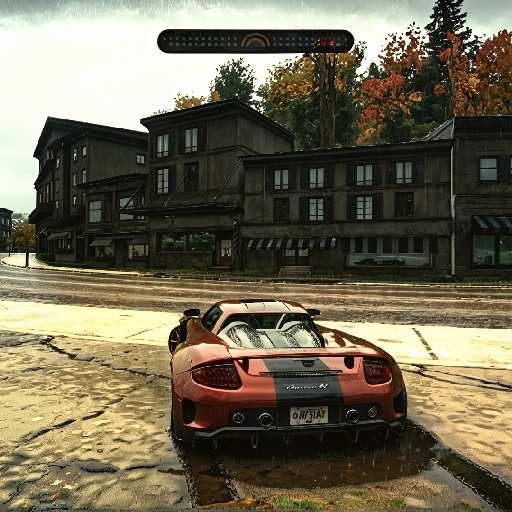

In [ ]:
from torchvision import transforms

T = transforms.Compose(
    [
        transforms.Resize(512, interpolation=transforms.InterpolationMode.NEAREST),
        transforms.CenterCrop(512),
    ]
)

T(dataset[0]["edited_image"])

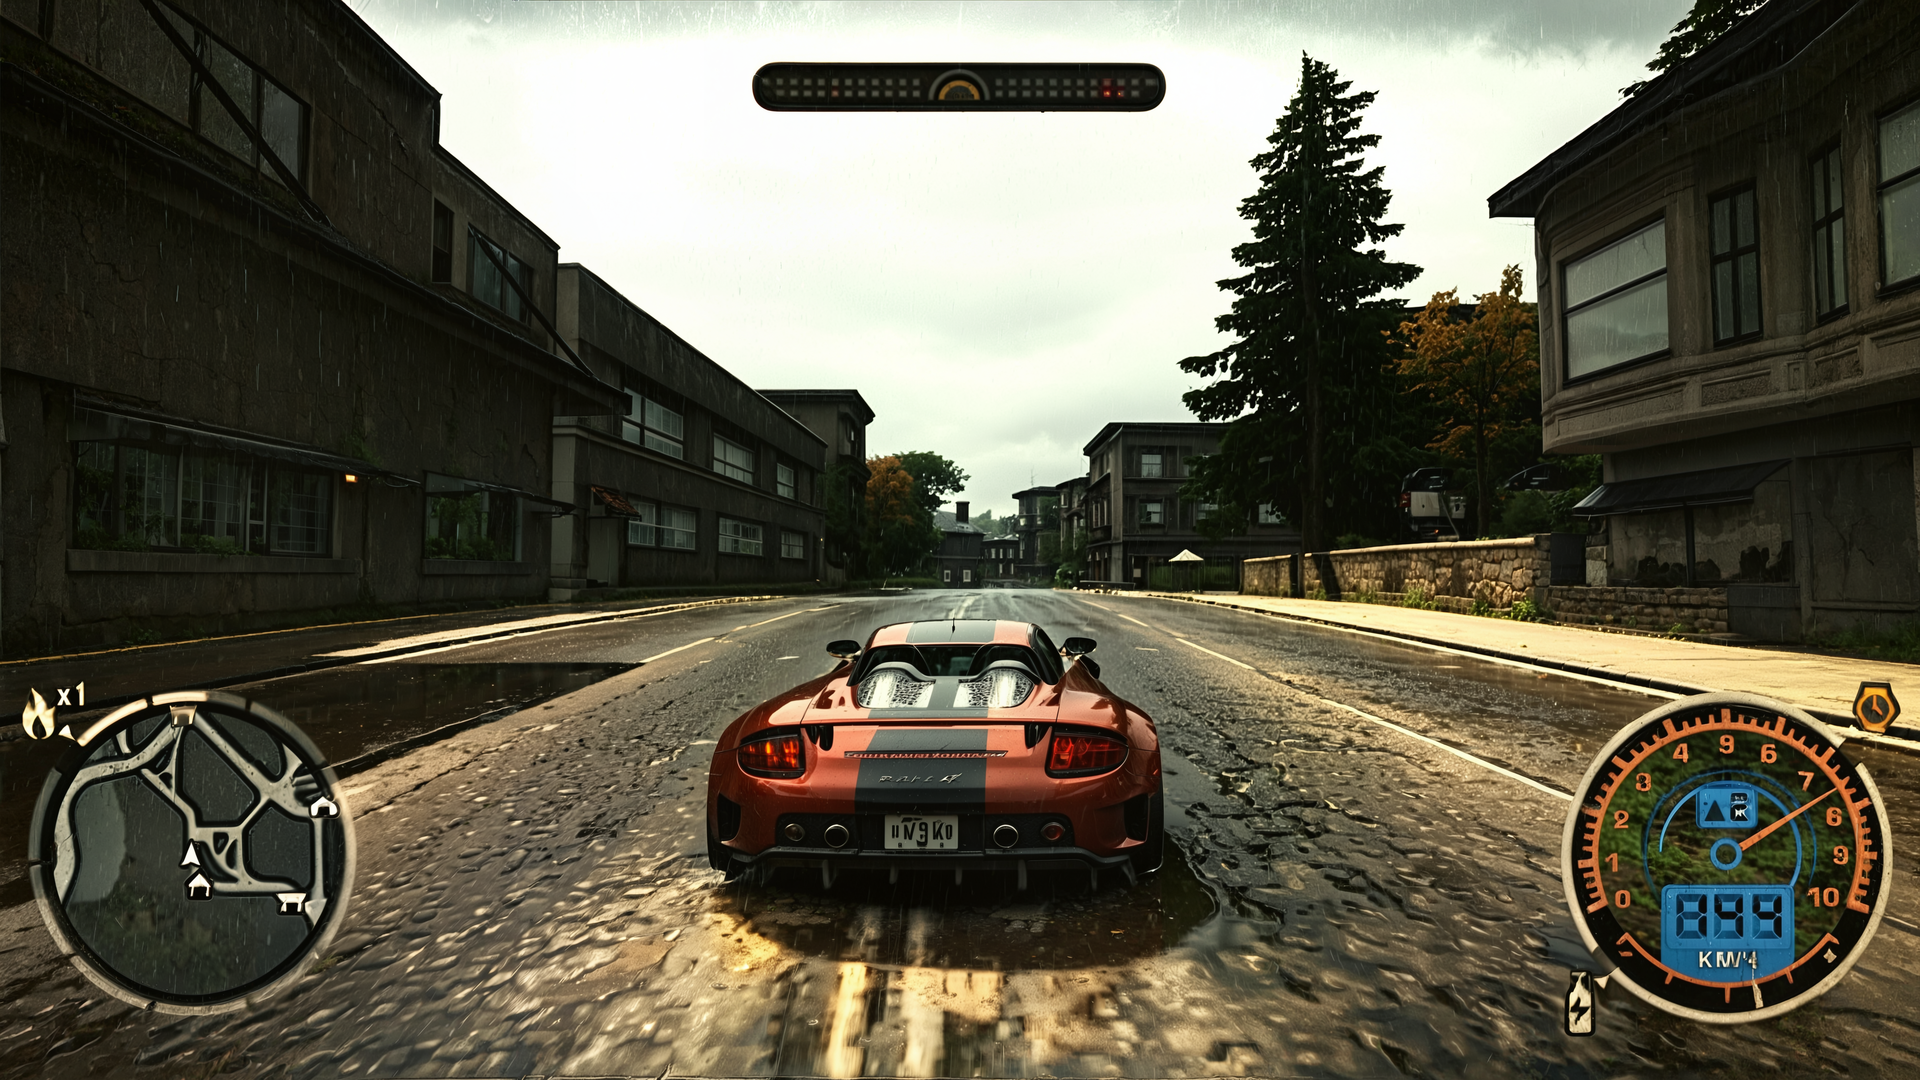

In [ ]:
dataset[100]["edited_image"]

### Mask Regions

In [15]:
import os
from pathlib import Path
from PIL import Image
import cv2
import numpy as np
from tqdm.notebook import tqdm
import concurrent
import imageio
from torchvision import transforms

image_folder = "comfyui_sandbox/video_renders/render_img2img_light_v6_1740323104"
images = sorted(list(Path(image_folder).glob("*.png")))
TO_PIL = transforms.ToPILImage()

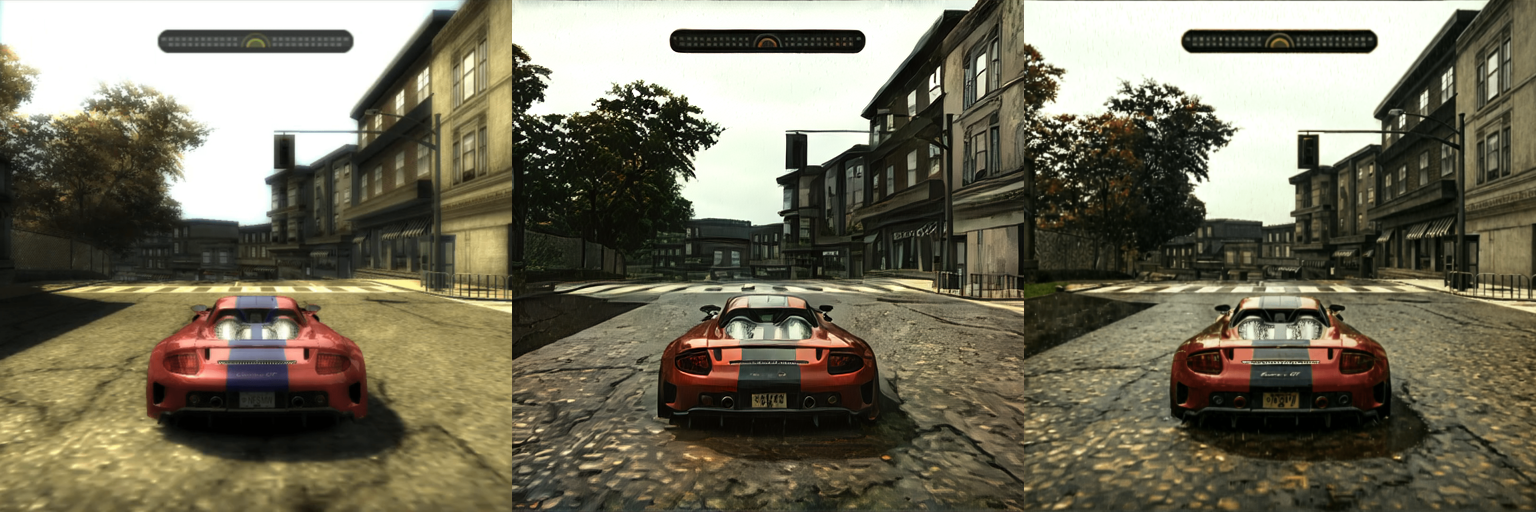

In [ ]:
image = Image.open(images[0])
TO_PIL(np.array(image))

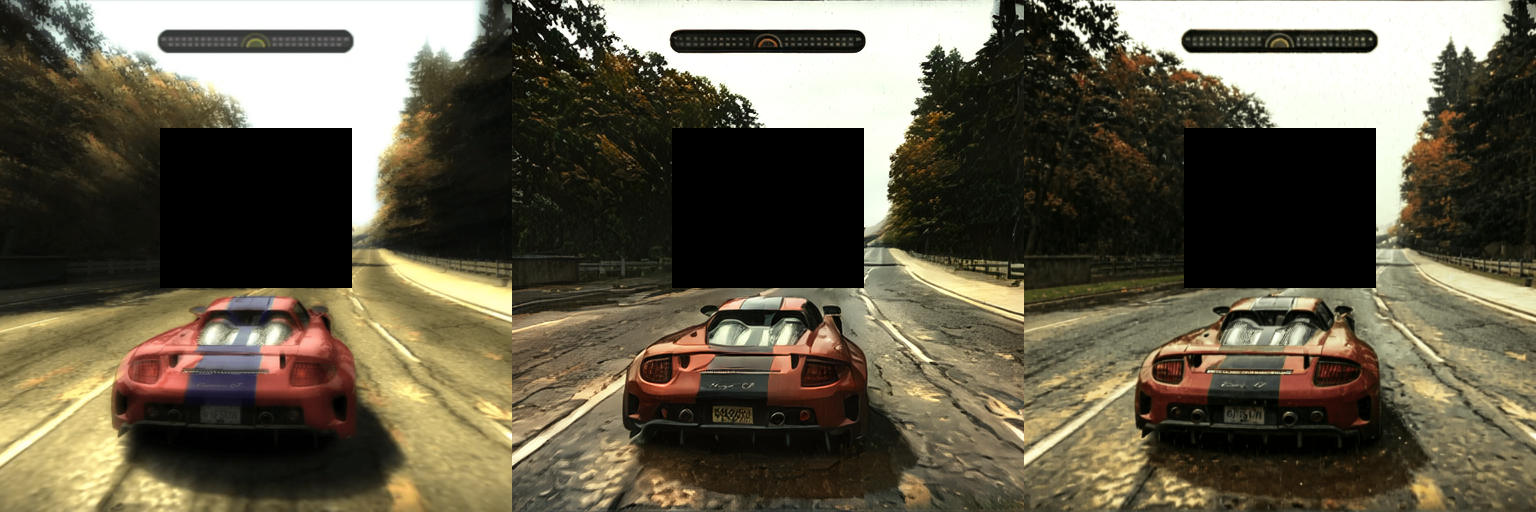

In [ ]:
pos = 120
image = Image.open(images[pos])
img_array = np.array(image)


def image_center_crop(image):
    start_x = 512
    square_size = 512 // 4
    start_y = 512 // 4
    shift = 32
    # first image
    img_array[
        # y
        start_y : start_y + square_size + square_size // 4,
        # x
        square_size + shift : square_size * 3 - shift,
    ] = 0
    # center image
    img_array[
        # y
        start_y : start_y + square_size + square_size // 4,
        # x
        start_x
        + square_size
        + shift : start_x
        + start_x // 4
        + square_size * 2
        - shift,
    ] = 0
    img_array[
        # y
        start_y : start_y + square_size + square_size // 4,
        # x
        start_x * 2
        + square_size
        + shift : start_x * 2
        + start_x // 4
        + square_size * 2
        - shift,
    ] = 0
    return TO_PIL(img_array)


image_center_crop(img_array)

In [85]:
output_path = (
    "comfyui_sandbox/video_renders/render_img2img_light_v6_1740323104_center_crop/"
)
os.system(f"mkdir -p {output_path}")

for item in tqdm(images):
    image = Image.open(item)
    img_array = np.array(image)
    out = image_center_crop(img_array)
    out.save(output_path + f"{item.stem}.png")
    # break

  0%|          | 0/830 [00:00<?, ?it/s]